In [1]:
import json
import os
from typing import List

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.plot
from rasterio.warp import calculate_default_transform, reproject, Resampling
from matplotlib.colors import ListedColormap
from stactools.core.utils.raster_footprint import RasterFootprint

In [5]:
def project_to_wgs84(href: str) -> str:
    dst_crs = "EPSG:4326"
    with rasterio.open(href) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        root, ext = os.path.splitext(href)
        wgs84_path = root + ".wgs84" + ext
        with rasterio.open(wgs84_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

    return wgs84_path


def manual_footprint(href: str) -> List[List[float]]:
    with rasterio.open(href) as src:
        data_array = src.read(1)
        crs = src.crs
        transform = src.transform

    footprint = RasterFootprint(data_array, crs, transform).footprint()
    footprint_coordinates = footprint["coordinates"][0]

    root, _ = os.path.splitext(href)
    footprint_path = root + ".grid_footprint.json"
    with open(footprint_path, "w") as file_out:
        json.dump(footprint, file_out)

    return footprint_coordinates


def plot_data_and_footprint(
        data_array,
        transform,
        crs,
        cmap,
        vmin,
        vmax,
        footprint_xs,
        footprint_ys,
        figsize,
        xlim,
        ylim,
        tick_spacing,
        title,
    ):
    fig, ax = plt.subplots(figsize=figsize)
    # ax.set_facecolor((0.9, 0.9, 0.9))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.xaxis.set_major_formatter("{x:0.1f}°")
    ax.yaxis.set_major_formatter("{x:0.1f}°")
    ax.xaxis.set_ticks(np.arange(xlim[0], xlim[1] + 0.1, tick_spacing))
    ax.yaxis.set_ticks(np.arange(ylim[0], ylim[1] + 0.1, tick_spacing))
    for tick in ax.get_yticklabels():
        tick.set_fontsize(9)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(9)
    ax.set_xlabel("Longitude (WGS84)", fontsize=9)
    ax.set_ylabel("Latitude (WGS84)", fontsize=9)
    ax.set_title(title, fontsize=10)
    # ax.spines["top"].set_visible(False)
    # ax.spines["right"].set_visible(False)
    # ax.spines["bottom"].set_visible(False)
    # ax.spines["left"].set_visible(False)

    cx.add_basemap(ax, crs=crs, source=cx.providers.CartoDB.Voyager, attribution=False)

    if data_array is not None:
        rasterio.plot.show(
            data_array,
            transform=transform,
            ax=ax,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            interpolation="nearest",
        )

    ax.plot(footprint_xs, footprint_ys, color="red", marker="o", markerfacecolor="red", markersize=5)
    return ax

## ESA WorldCover

In [3]:
esaworldcover = "data/esa-worldcover/ESA_WorldCover_10m_2020_v100_S33E120_Map.tif"
with rasterio.open(esaworldcover) as src:
    data_array = src.read(1)
    crs = src.crs
    transform = src.transform
    colormap_def = src.colormap(1)
    bounds = src.bounds

footprint_coordinates = manual_footprint(esaworldcover)

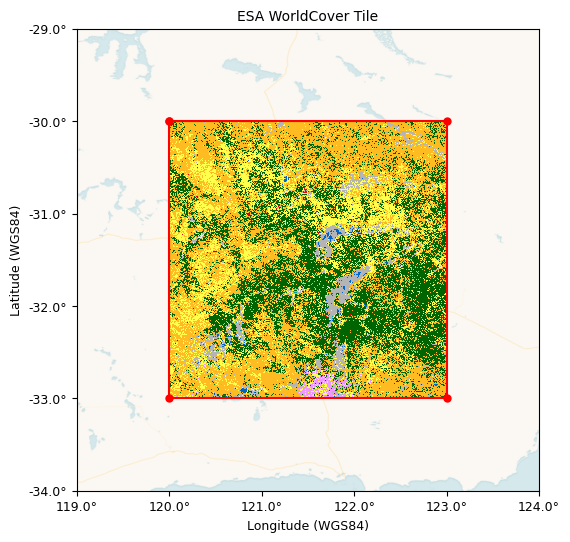

In [6]:
cmap = ListedColormap([np.array(colormap_def[i]) / 255 for i in range(len(colormap_def))])
vmin = 0
vmax = (len(colormap_def) - 1)

offset = 1
xlim = [bounds[0] - offset, bounds[2] + offset]
ylim = [bounds[1] - offset, bounds[3] + offset]
tick_spacing = 1

xs, ys = zip(*footprint_coordinates)

ax = plot_data_and_footprint(
    data_array=data_array,
    transform=transform,
    crs=crs,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    footprint_xs=xs,
    footprint_ys=ys,
    figsize=(6,6),
    xlim=xlim,
    ylim=ylim,
    tick_spacing=tick_spacing,
    title="ESA WorldCover Tile",
)

plt.show()

## MODIS LST

In [7]:
modis_lst = "data/modis/MYD11A2/MYD11A2.A2023049.h28v11.061.2023059153505/MYD11A2.A2023049.h28v11.061.2023059153505_LST_Day_1km.tif"
modis_lst = "data/modis/MYD11A2/MYD11A2.A2023049.h12v02.061.2023059154534/MYD11A2.A2023049.h12v02.061.2023059154534_LST_Day_1km.tif"
modis_lst = "data/modis/MYD11A2/MYD11A2.A2023049.h12v04.061.2023059153953/MYD11A2.A2023049.h12v04.061.2023059153953_LST_Day_1km.tif"
modis_lst = "data/modis/MYD11A2/MYD11A2.A2023049.h12v12.061.2023059153602/MYD11A2.A2023049.h12v12.061.2023059153602_LST_Day_1km.tif"
modis_lst = "data/modis/MYD11A2/MOD11A2.A2023049.h29v11.061.2023059153030/MOD11A2.A2023049.h29v11.061.2023059153030_LST_Day_1km.tif"
modis_lst_wgs84 = project_to_wgs84(modis_lst)

with rasterio.open(modis_lst_wgs84) as src:
    data_array = src.read(1)
    crs = src.crs
    transform = src.transform
    bounds = src.bounds
    nodata = src.nodata

footprint_coordinates = manual_footprint(modis_lst)

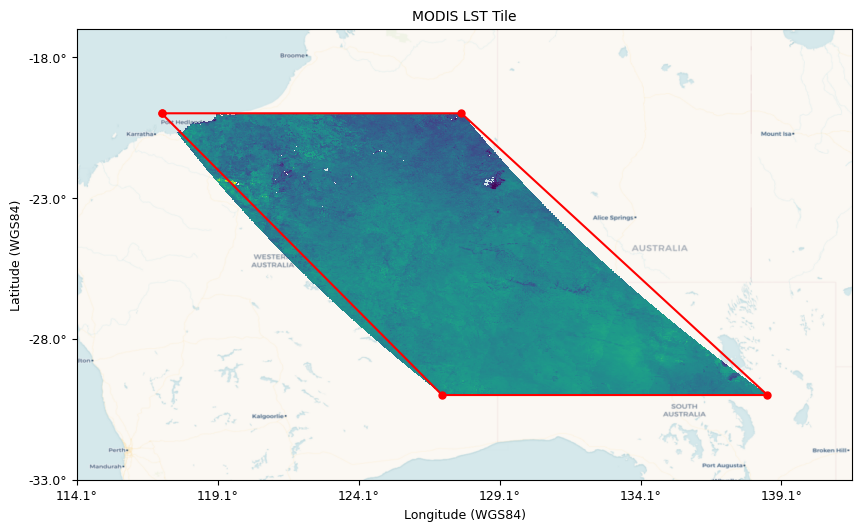

In [8]:
masked_data_array = np.ma.masked_where(data_array==nodata, data_array)
cmap = "viridis"
vmin = np.min(masked_data_array)
vmax = np.max(masked_data_array)

offset = 3
xlim = [bounds[0] - offset, bounds[2] + offset]
ylim = [bounds[1] - offset, bounds[3] + offset]
tick_spacing = 5

xs, ys = zip(*footprint_coordinates)

ax = plot_data_and_footprint(
    data_array=masked_data_array,
    transform=transform,
    crs="EPSG:4326",
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    footprint_xs=xs,
    footprint_ys=ys,
    figsize=(10, 10),
    xlim=xlim,
    ylim=ylim,
    tick_spacing=tick_spacing,
    title="MODIS LST Tile",
)

plt.show()